### DA Question 1: Rider Behavior Analysis
- What are the purposes of the rides?  Hypothesize based on common sense.
    Estimate the proportions of rides which are riders commuting for works.
- What are the characteristics of the riders in terms of age/gender?
- How are the ride-demand change with respect to time? Analyze the daily ride-count growth as a time series.
- Analyze the variations of ride-counts w.r.t. months. What seasonality do you observe? What is the likely reason for
    the seasonality?
- Analyze the variations of ride-counts w.r.t. weekdays or hours? What are the popular hours when **citibikes** are in high demand?
- During the rush hours, what are the hot-spots (popular dock-stations) for trip initialization/destination?
- During the non-rush hours or weekends, what are the popular starting/destination dock stations?
- Find out the transition probabilities between different dock-stations. Does this depend significantly on the weekday or hours?
- Based on the lat-long coordinates of the trips, identify the start dates of the dock-stations.
- Study the strategy **motivate** increase its bike-fleet and dock stations in terms of locations and counts.
- Open Question: **CityBike** has set the target bike-fleet count to saturate at $40000$. In order to set this number,
    what factors need to be considered in setting this target? Please project the growth of the bike fleet as time series.
- Estimate the growth of operating revenue of the bike sharing business, excluding sponsorship. Do not overlook the investment revenue from
annual subscription and deposits ($101$) for short-term subscriptions.
- Ride distance/Speed Case study: As the lat-long coordinates of the start-location and stop-location are known, the minimal trip distance
    can be estimated. Due to the nature of Manhattan city blocks, the minimal trip distances are not the straight line distances
(see the following diagram).
Study the trip distance/duration/speed distribution and their dependence on location/time/weekday/month.
${\bf footnote}: **CitiBike** uses $7.456$ miles/hour average speed to estimate trip distance from trip duration.
- Justify the time/economical advantage of shared-bike compared to yellow-caps with or without traffic jams.
- You will need to utilize yellow taxi data to justify its superiority.
- The price/time-saving advantage determines the incentives to switch from taxi-rides to shared-bikes for short distance trips.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as datetime
import matplotlib.dates as mdates

### Read 2019 data and drop missing rows

In [2]:
NY_2019 = pd.read_csv("data/NY_2019.csv")
NY_2019.drop('Unnamed: 0', axis=1, inplace=True)

In [3]:
# we are missing some dock station data for 180 rows
NY_2019.isna().sum()

tripduration               0
starttime                  0
stoptime                   0
startstationid           180
startstationname         180
startstationlatitude       0
startstationlongitude      0
endstationid             180
endstationname           180
endstationlatitude         0
endstationlongitude        0
bikeid                     0
usertype                   0
birthyear                  0
gender                     0
dtype: int64

In [4]:
# rows with missing values (dock stations)
NY_2019[NY_2019.isna().values.any(axis=1)]

,tripduration,starttime,stoptime,startstationid,startstationname,startstationlatitude,startstationlongitude,endstationid,endstationname,endstationlatitude,endstationlongitude,bikeid,usertype,birthyear,gender
248483,2358,2019-01-08 13:48:13.8120,2019-01-08 14:27:32.0160,NaN,NaN,40.854,-73.890,NaN,NaN,40.857,-73.881,34550,Subscriber,1992,1
249690,3358,2019-01-08 14:29:31.5150,2019-01-08 15:25:29.7130,NaN,NaN,40.857,-73.884,NaN,NaN,40.857,-73.884,34550,Subscriber,1992,1
336359,596,2019-01-10 14:35:39.2120,2019-01-10 14:45:35.4130,NaN,NaN,40.863,-73.890,NaN,NaN,40.866,-73.884,34550,Subscriber,1986,1
337008,816,2019-01-10 14:56:38.4250,2019-01-10 15:10:14.8120,NaN,NaN,40.857,-73.890,NaN,NaN,40.854,-73.902,34447,Subscriber,1986,1
396461,393,2019-01-12 12:36:01.1440,2019-01-12 12:42:34.9520,NaN,NaN,40.854,-73.890,NaN,NaN,40.857,-73.884,34536,Customer,1997,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13292288,419,2019-08-28 04:56:24.0760,2019-08-28 05:03:23.5780,NaN,NaN,40.860,-73.899,NaN,NaN,40.860,-73.887,34428,Customer,1998,1
13292321,856,2019-08-28 05:05:22.3540,2019-08-28 05:19:39.2880,NaN,NaN,40.860,-73.887,NaN,NaN,40.848,-73.908,34428,Customer,1998,1
13292453,949,2019-08-28 05:23:29.6880,2019-08-28 05:39:19.6870,NaN,NaN,40.848,-73.908,NaN,NaN,40.854,-73.902,34428,Customer,1998,1
13293165,739,2019-08-28 06:09:32.5250,2019-08-28 06:21:52.2510,NaN,NaN,40.854,-73.899,NaN,NaN,40.848,-73.902,34428,Customer,1998,1


In [5]:
# drop the 180 rows
NY_2019.dropna(axis=0, inplace=True)

### Birthyear/Age and Gender

In [7]:
# https://stackoverflow.com/questions/36271302/changing-color-scale-in-seaborn-bar-plot
def colors_from_values(values: pd.Series, palette_name:str, ascending=True):
    # convert to indices
    values = values.sort_values(ascending=ascending).reset_index()
    indices = values.sort_values(by=values.columns[0]).index
    # use the indices to get the colors
    palette = sns.color_palette(palette_name, len(values))
    return np.array(palette).take(indices, axis=0)

In [13]:
birthyears = NY_2019[['birthyear']].value_counts().reset_index().rename(columns={0: 'countbirthyear'}).sort_values(by='birthyear', ascending=False)
birthyears

,birthyear,countbirthyear
58,2003,10289
54,2002,27084
48,2001,62450
43,2000,124094
40,1999,161942
...,...,...
84,1885,269
117,1880,1
110,1874,5
115,1863,2


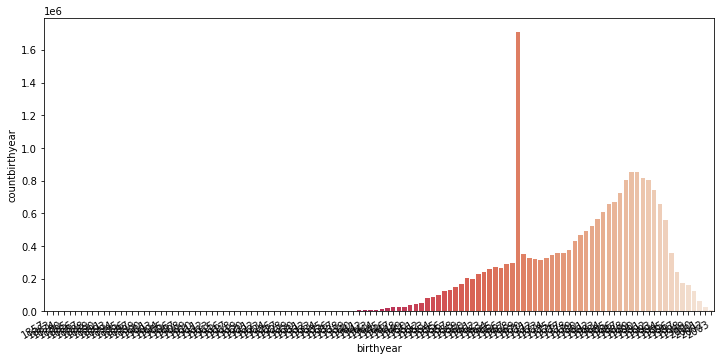

In [14]:
# lot of 1969 births???
# sns.barplot(data=birthyears, x='birthyear', y='countbirthyear')
fig, ax = plt.subplots()
fig.set_size_inches(12,6)
sns.barplot(data=birthyears, x='birthyear', y='countbirthyear', palette=colors_from_values(birthyears.countbirthyear, "rocket_r"))
fig.autofmt_xdate()
plt.show()

# Delete from memory. NOTE: Can verify it is gone with `who_ls`
del birthyears

In [29]:
# by age. we see most riders are between 20 and 50 years
ages = NY_2019[['birthyear', 'gender']]
ages['age'] = 2019 - ages['birthyear']
age_bins = [0, 20, 30, 40, 50, 60, 70, 1000]
age_labels = ['<20', '20-29', '30-39', '40-49', '50-59', '60-69', '70+']
ages['agerange'] = pd.cut(ages.age, bins=age_bins, labels=age_labels, include_lowest=True)
ages

ageranges = ages.drop('birthyear', axis=1).groupby(['agerange', 'gender']).agg('sum').reset_index().rename(columns={'age': 'count'})
ageranges['gender'] = ageranges['gender'].replace({1: 'male', 2: 'female', 0: 'unknown'})
ageranges = ageranges[ageranges['gender'] != 'unknown']


/var/folders/zx/f3rt3pyx58xg7vm_jv6_g3jh0000gn/T/ipykernel_91700/2701200178.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ages['age'] = 2019 - ages['birthyear']
/var/folders/zx/f3rt3pyx58xg7vm_jv6_g3jh0000gn/T/ipykernel_91700/2701200178.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ages['agerange'] = pd.cut(ages.age, bins=age_bins, labels=age_labels, include_lowest=True)


/opt/anaconda3/envs/python310/lib/python3.10/site-packages/seaborn/axisgrid.py:670: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


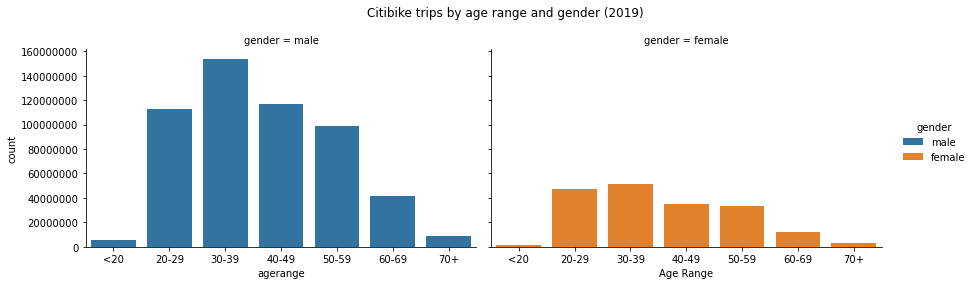

In [30]:
# plot riders by age and gender
g = sns.FacetGrid(ageranges, col='gender', hue='gender', height=4, aspect=1.5, sharey=True)
g.map(sns.barplot, 'agerange', 'count')
g.fig.subplots_adjust(top=0.9)
g.fig.suptitle("Citibike trips by age range and gender (2019)")
g.add_legend()
g.tight_layout()
plt.ticklabel_format(style='plain', axis='y')
plt.xlabel("Age Range")
plt.ylabel("Count")
plt.show()

# Remove from memory
del ages, ageranges, age_bins, age_labels

In [25]:
# gender counts
genders = NY_2019[['gender']].value_counts().reset_index().rename(columns={0: 'count'})
genders['gender'] = genders['gender'].replace({1: 'male', 2: 'female', 0: 'unknown'})
genders

,gender,count
0,male,14052230
1,female,4938982
2,unknown,1560305


In [26]:
# gender percent
NY_2019['gender'].value_counts(normalize=True).round(4).mul(100)

1    68.38
2    24.03
0     7.59
Name: gender, dtype: float64

In [27]:
del genders

### Trips by day, month, hour

In [31]:
# ride count by trip start-day, -month, -hour
NY_2019['starttime'] = pd.to_datetime(NY_2019['starttime'])
NY_2019['day'] = NY_2019['starttime'].dt.day
NY_2019['month'] = NY_2019['starttime'].dt.month
NY_2019['dayofyear'] = NY_2019['starttime'].dt.dayofyear
NY_2019['hour'] = NY_2019['starttime'].dt.hour
NY_2019['dayofweek'] = NY_2019['starttime'].dt.dayofweek
NY_2019['isweekday'] = NY_2019['starttime'].dt.weekday # 1 if weekday, 0 if weekend

In [32]:
trips_per_day = NY_2019.groupby(['dayofyear'])['tripduration'].count().reset_index().rename(columns={'tripduration': 'counttrips'})

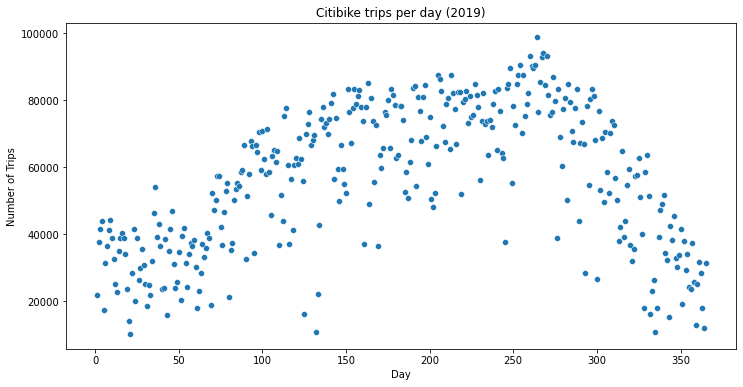

In [33]:
# Plot trips per day
plt.figure(figsize=(12,6))
sns.scatterplot(data=trips_per_day, x='dayofyear', y='counttrips')
plt.title("Citibike trips per day (2019)")
plt.xlabel("Day")
plt.ylabel("Number of Trips")
# TODO set xticklabels to use ConciseDateFormatter
plt.show()

del trips_per_day

In [34]:
trips_per_month = NY_2019.groupby(['month'])['tripduration'].count().reset_index().rename(columns={'tripduration': 'counttrips'})

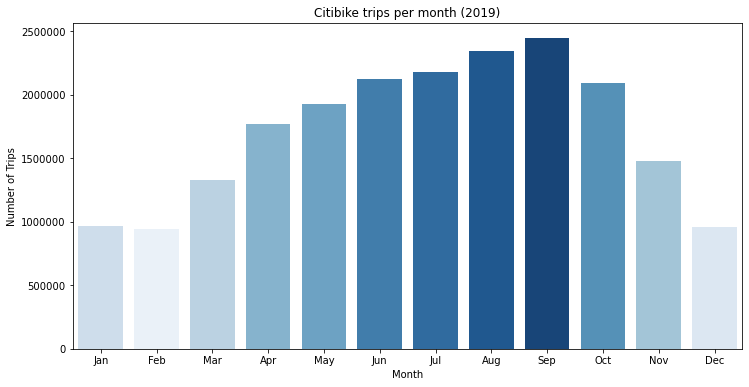

In [35]:
# Plot trips per month
fig, ax = plt.subplots()
fig.set_size_inches(12,6)
sns.barplot(data=trips_per_month, x='month', y='counttrips', palette=colors_from_values(trips_per_month.counttrips, 'Blues'), ax=ax)
plt.title("Citibike trips per month (2019)")

# set month labels
plt.xlabel("Month")
monthlabels = [datetime.date(1900, month+1, 1).strftime('%b') for month in trips_per_month.index]
ax.set_xticks(np.arange(0,12))
ax.set_xticklabels(monthlabels)

plt.ylabel("Number of Trips")
plt.ticklabel_format(style='plain', axis='y')
plt.show()

del trips_per_month

In [36]:
# trips by hour of day (and weekend/weekday)
trips_per_hour = NY_2019.groupby(['hour'])['tripduration'].count().reset_index().rename(columns={'tripduration': 'counttrips'})

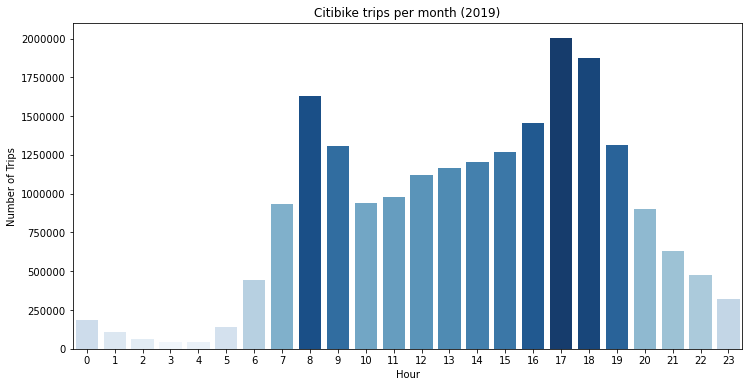

In [38]:
# Plot trips by hour of day
fig, ax = plt.subplots()
fig.set_size_inches(12,6)
sns.barplot(data=trips_per_hour, x='hour', y='counttrips', palette=colors_from_values(trips_per_hour.counttrips, 'Blues'), ax=ax)
plt.title("Citibike trips per hour (2019)")

plt.xlabel("Hour")
plt.ylabel("Number of Trips")
plt.ticklabel_format(style='plain', axis='y')
plt.show()

del trips_per_hour